In [1]:
# ┌── Block 1: Install & Load Dataset ────────────────────────────────────────
!pip install kagglehub[pandas-datasets]  # if not already installed

import kagglehub
import os

# Download (or locate) the dataset
_ = kagglehub.dataset_download("juhibhojani/house-price")
DATA_PATH = "/kaggle/input/house-price"

# List files to confirm
print("Files:", os.listdir(DATA_PATH))

import pandas as pd
df = pd.read_csv(f"{DATA_PATH}/house_prices.csv")
print("Raw shape:", df.shape)
df.head()


Files: ['house_prices.csv']
Raw shape: (187531, 21)


,Index,Title,Description,Amount(in rupees),Price (in rupees),location,Carpet Area,Status,Floor,Transaction,...,facing,overlooking,Society,Bathroom,Balcony,Car Parking,Ownership,Super Area,Dimensions,Plot Area
0,0,1 BHK Ready to Occupy Flat for sale in Srushti...,"Bhiwandi, Thane has an attractive 1 BHK Flat f...",42 Lac,6000.0,thane,500 sqft,Ready to Move,10 out of 11,Resale,...,NaN,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN
1,1,2 BHK Ready to Occupy Flat for sale in Dosti V...,One can find this stunning 2 BHK flat for sale...,98 Lac,13799.0,thane,473 sqft,Ready to Move,3 out of 22,Resale,...,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN
2,2,2 BHK Ready to Occupy Flat for sale in Sunrise...,Up for immediate sale is a 2 BHK apartment in ...,1.40 Cr,17500.0,thane,779 sqft,Ready to Move,10 out of 29,Resale,...,East,Garden/Park,Sunrise by Kalpataru,2,NaN,1 Covered,Freehold,NaN,NaN,NaN
3,3,1 BHK Ready to Occupy Flat for sale Kasheli,This beautiful 1 BHK Flat is available for sal...,25 Lac,NaN,thane,530 sqft,Ready to Move,1 out of 3,Resale,...,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN
4,4,2 BHK Ready to Occupy Flat for sale in TenX Ha...,"This lovely 2 BHK Flat in Pokhran Road, Thane ...",1.60 Cr,18824.0,thane,635 sqft,Ready to Move,20 out of 42,Resale,...,West,"Garden/Park, Main Road",TenX Habitat Raymond Realty,2,NaN,1 Covered,Co-operative Society,NaN,NaN,NaN


In [2]:
# ─── Block 2a: Debug raw sale-price values ───────────────────────────────────
print("Sample sale prices (raw strings):")
print(df['Amount(in rupees)'].head(20).tolist())
print("\nUnique patterns:", pd.Series(df['Amount(in rupees)'].unique()).dropna().tolist()[:10])
print("\nMissing count:", df['Amount(in rupees)'].isna().sum(), "of", len(df))


Sample sale prices (raw strings):
['42 Lac ', '98 Lac ', '1.40 Cr ', '25 Lac ', '1.60 Cr ', '45 Lac ', '16.5 Lac ', '60 Lac ', '60 Lac ', '1.60 Cr ', '1.40 Cr ', '1.36 Cr ', '1.35 Cr ', '4.25 Cr ', '75 Lac ', '90 Lac ', '37 Lac ', '35 Lac ', '90 Lac ', '35 Lac ']

Unique patterns: ['42 Lac ', '98 Lac ', '1.40 Cr ', '25 Lac ', '1.60 Cr ', '45 Lac ', '16.5 Lac ', '60 Lac ', '1.36 Cr ', '1.35 Cr ']

Missing count: 0 of 187531


In [3]:
# ─── Block 2 (Final Revision): Cleaning & Feature Engineering ────────────
import numpy as np
import pandas as pd
import re

# 1️⃣ Parse area columns (“123 sqft”, “49 sqm”, “10,000”, plain numbers)
def parse_area(x):
    s = str(x).strip().lower().replace(',', '')
    if s.endswith('sqft'):
        return float(s[:-4].strip())
    if s.endswith('sqm'):
        return float(s[:-3].strip()) * 10.7639
    try:
        return float(s)
    except:
        return np.nan

for col in ['Carpet Area', 'Super Area']:
    df[col] = df[col].apply(parse_area)

# 2️⃣ Extract floor number (drop basements)
if 'Floor' in df.columns:
    df = df[~df['Floor'].str.contains('basement', na=False, case=False)].copy()
    def extract_floor(x):
        t = str(x).lower()
        if 'out of' in t:
            cur = t.split('out of')[0].strip()
            return 0 if cur == 'ground' else int(cur)
        try:
            return int(t)
        except:
            return np.nan
    df['Floor_Num'] = df['Floor'].apply(extract_floor)
    df.drop(columns=['Floor','Total_Floors'], inplace=True, errors='ignore')

# 3️⃣ Cast baths & balconies to numeric
df['Bathroom'] = pd.to_numeric(df.get('Bathroom'), errors='coerce')
df['Balcony']  = pd.to_numeric(df.get('Balcony'),  errors='coerce')

# 4️⃣ Robust sale‐price conversion (“42 Lac ”, “1.40 Cr ”, commas, currency symbols)
def to_rupees(x):
    if isinstance(x, str):
        s = x.strip().lower()
        # strip currency symbols and commas
        s = re.sub(r'[₹,]\s*', '', s)
        if s == '':
            return np.nan
        if s.endswith('cr'):
            return float(s[:-2].strip()) * 1e7
        if s.endswith('lac'):
            return float(s[:-3].strip()) * 1e5
        # fallback: keep only digits/dot
        num = re.sub(r'[^\d\.]', '', s)
        return float(num) if num else np.nan
    return x

df['Amount(in rupees)'] = df['Amount(in rupees)'].apply(to_rupees)

# 5️⃣ Drop the empty rent column
df.drop(columns=['Price (in rupees)'], inplace=True, errors='ignore')

# 6️⃣ Drop high-card text columns
to_drop = ['Index','Title','Description','location',
           'Society','Car Parking','Plot Area','Dimensions']
df.drop(columns=[c for c in to_drop if c in df.columns], inplace=True)

# 7️⃣ One‐hot encode categoricals
cats = ['Transaction','Furnishing','facing','overlooking','Ownership','Status']
df = pd.get_dummies(df, columns=[c for c in cats if c in df.columns], drop_first=True)

# 8️⃣ Fill non‐target NaNs with defaults
df['Floor_Num']   = df['Floor_Num'].fillna(df['Floor_Num'].median())
df['Bathroom']    = df['Bathroom'].fillna(df['Bathroom'].median())
df['Balcony']     = df['Balcony'].fillna(0)
df['Carpet Area'] = df['Carpet Area'].fillna(df['Carpet Area'].median())
df['Super Area']  = df['Super Area'].fillna(df['Super Area'].median())

# 9️⃣ Drop only rows still missing the sale price
df = df.dropna(subset=['Amount(in rupees)'])

print("✅ Shape after cleaning:", df.shape)


✅ Shape after cleaning: (177512, 39)


Top correlations with Amount(in rupees):
Amount(in rupees)                           1.000000
Bathroom                                    0.213536
Super Area                                  0.115818
Balcony                                     0.101775
Floor_Num                                   0.099707
Ownership_Freehold                          0.069473
facing_North - East                         0.055378
Carpet Area                                 0.047446
overlooking_Garden/Park, Pool               0.042794
overlooking_Garden/Park, Pool, Main Road    0.034154
Name: Amount(in rupees), dtype: float64


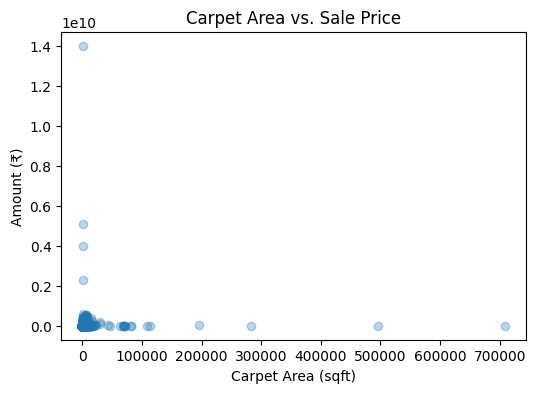

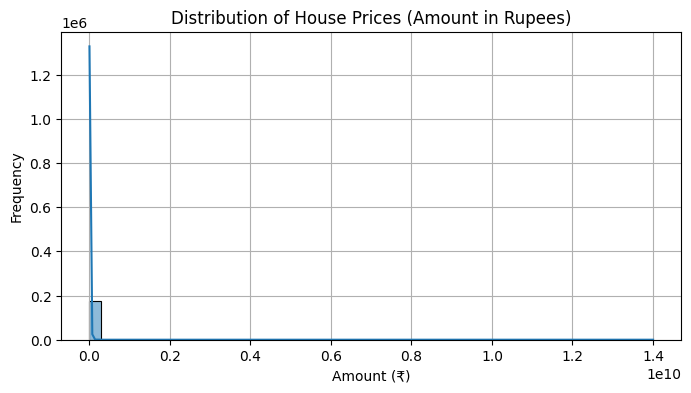

In [4]:
# ┌── Block 3: Exploratory Data Analysis ────────────────────────────────────
import matplotlib.pyplot as plt

# 3.1 Correlation of numeric features with sale price
corr = df.corr()['Amount(in rupees)'].sort_values(ascending=False)
print("Top correlations with Amount(in rupees):")
print(corr.head(10))

# 3.2 Scatter plot: Carpet Area vs. Amount(in rupees)
plt.figure(figsize=(6,4))
plt.scatter(df['Carpet Area'], df['Amount(in rupees)'], alpha=0.3)
plt.xlabel('Carpet Area (sqft)')
plt.ylabel('Amount (₹)')
plt.title('Carpet Area vs. Sale Price')
plt.show()

# Distribution of Target Variable (Amount in Rupees)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(df['Amount(in rupees)'], kde=True, bins=50)
plt.title('Distribution of House Prices (Amount in Rupees)')
plt.xlabel('Amount (₹)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


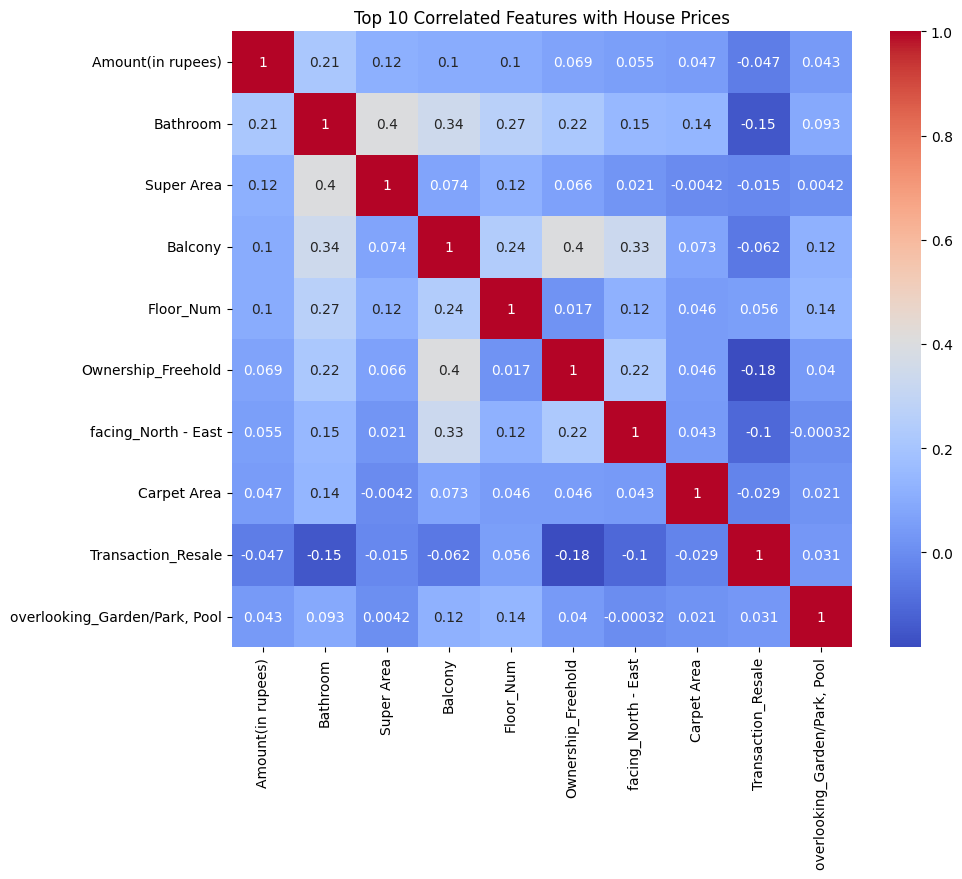

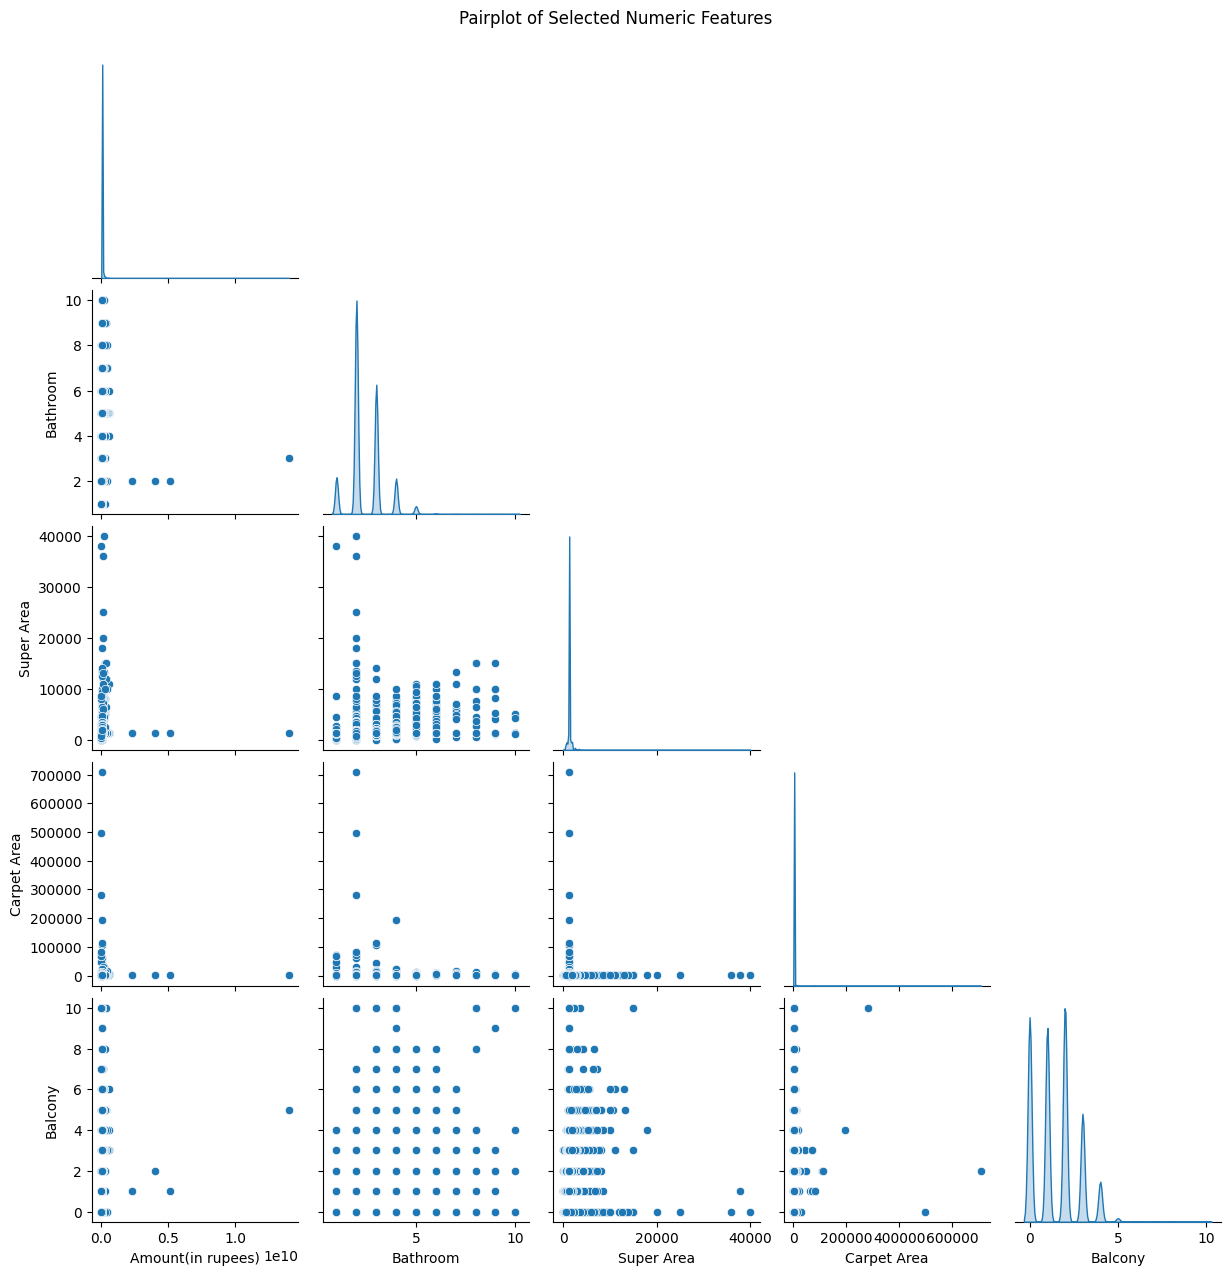

In [5]:
#Correlation Heatmap (Top 10 features correlated with Price)
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
top_corr_features = corr_matrix['Amount(in rupees)'].abs().sort_values(ascending=False).head(10).index
sns.heatmap(df[top_corr_features].corr(), annot=True, cmap='coolwarm')
plt.title('Top 10 Correlated Features with House Prices')
plt.show()

#Pairplots of Most Correlated Numeric Features
selected_features = ['Amount(in rupees)', 'Bathroom', 'Super Area', 'Carpet Area', 'Balcony']

sns.pairplot(df[selected_features], diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Selected Numeric Features', y=1.02)
plt.show()



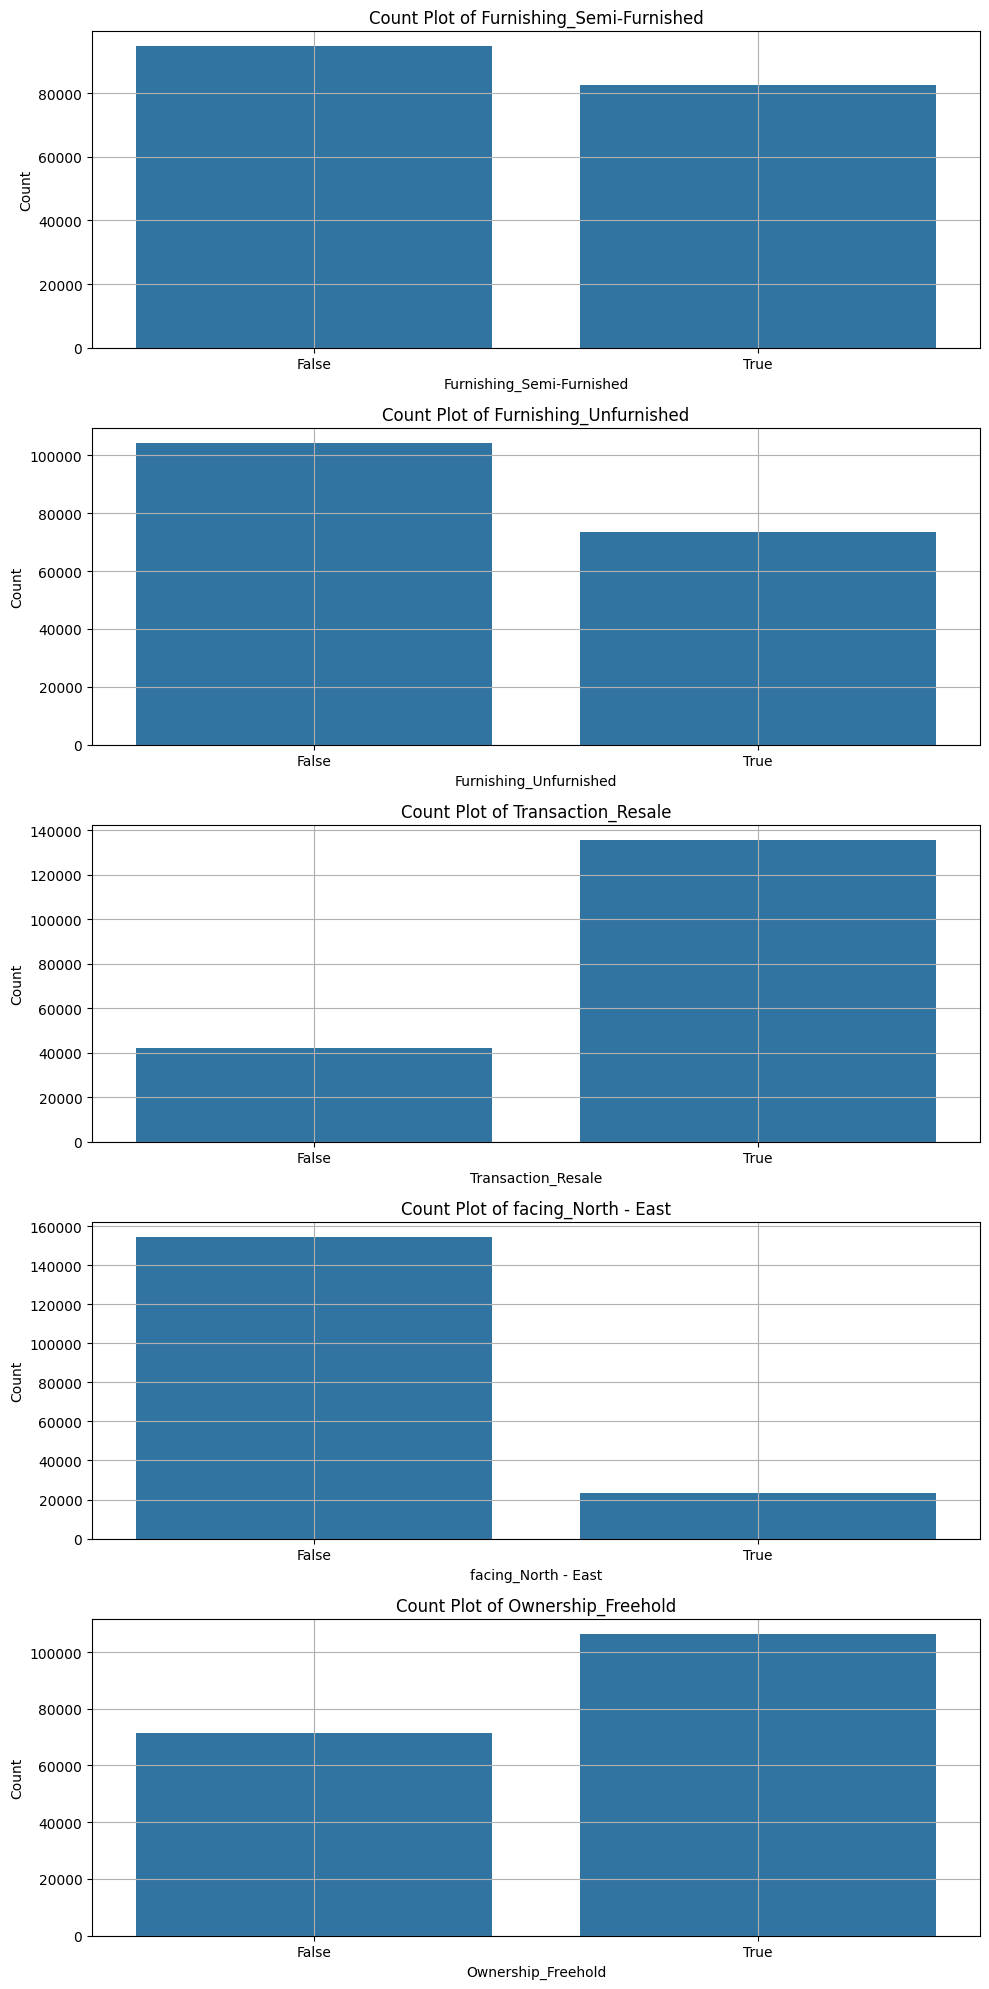

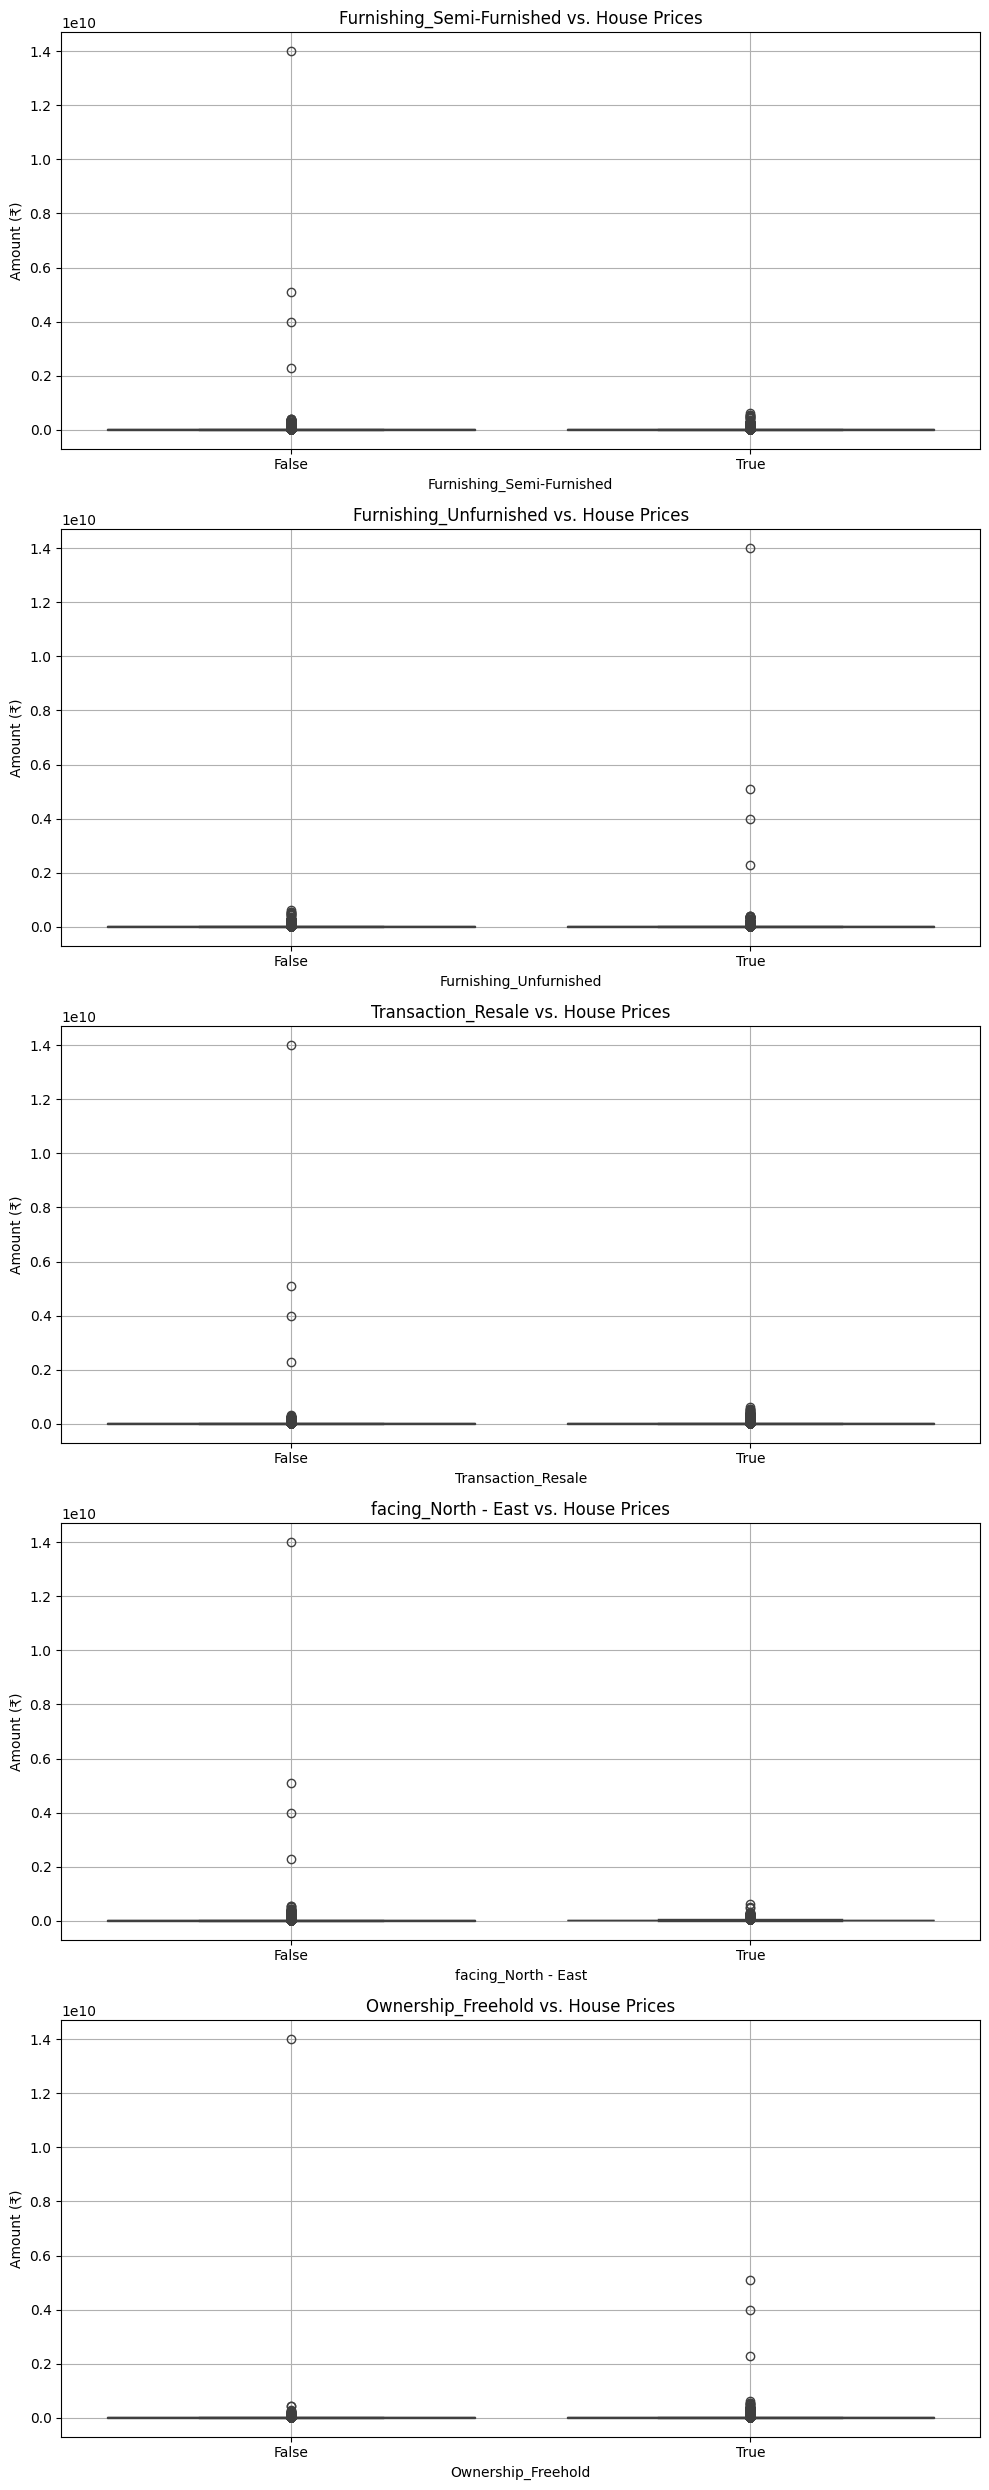

In [6]:
#Count Plot of Categorical Features
categorical_cols = ['Furnishing_Semi-Furnished', 'Furnishing_Unfurnished',
                    'Transaction_Resale', 'facing_North - East', 'Ownership_Freehold']

fig, axes = plt.subplots(len(categorical_cols), 1, figsize=(10, 4 * len(categorical_cols)))

for i, col in enumerate(categorical_cols):
    sns.countplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Count Plot of {col}')
    axes[i].set_xlabel(f'{col}')
    axes[i].set_ylabel('Count')
    axes[i].grid(True)

plt.tight_layout()
plt.show()
#Boxplots: Categorical Features vs. Price
categorical_cols = ['Furnishing_Semi-Furnished', 'Furnishing_Unfurnished',
                    'Transaction_Resale', 'facing_North - East', 'Ownership_Freehold']

fig, axes = plt.subplots(len(categorical_cols), 1, figsize=(10, 5 * len(categorical_cols)))

for i, col in enumerate(categorical_cols):
    sns.boxplot(x=df[col], y=df['Amount(in rupees)'], ax=axes[i])
    axes[i].set_title(f'{col} vs. House Prices')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Amount (₹)')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [7]:
# ┌── Block 4: Prepare Features & Target ────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 4.1 Define X and y
X = df.drop(columns=['Amount(in rupees)'])
y = df['Amount(in rupees)'].values

# 4.2 Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4.3 Scale all features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [8]:
# ┌── Block 5: Train & Evaluate Regression Models ──────────────────────────
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression' : Ridge(alpha=1.0),
    'Polynomial (deg=2)': make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False),
        LinearRegression()
    )
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results[name] = (mse, rmse)

print("\nModel Performance:")
for name, (mse, rmse) in results.items():
    print(f"{name:<20} MSE = {mse:,.2f} │ RMSE = {rmse:,.2f}")



Model Performance:
Linear Regression    MSE = 265,612,930,516,973.12 │ RMSE = 16,297,635.73
Ridge Regression     MSE = 265,612,948,406,462.81 │ RMSE = 16,297,636.28
Polynomial (deg=2)   MSE = 18,405,134,757,330,224.00 │ RMSE = 135,665,525.31
